Shape of X: (1, 19)
Shape of y: (1,)
Training data size: 1
Testing data size: 1
Epoch 1/50


d:\Assessment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0567
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0469
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0290
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0271
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4423e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0219e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.7988e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0176
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0161
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0177
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8122e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0105
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━

Test MSE: 6.57172713545151e-05


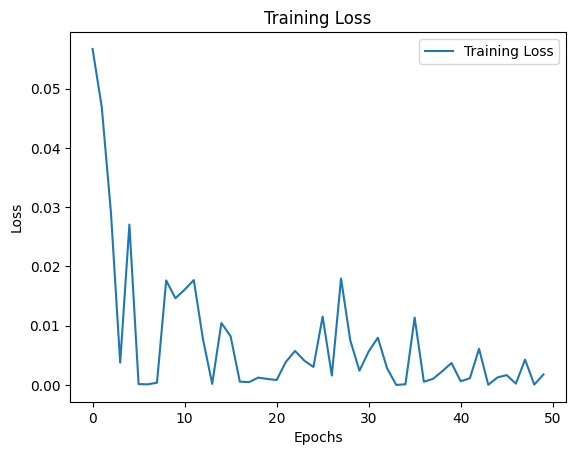

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
First 5 predictions: [797.1915]
First 5 actual values: [796.79]


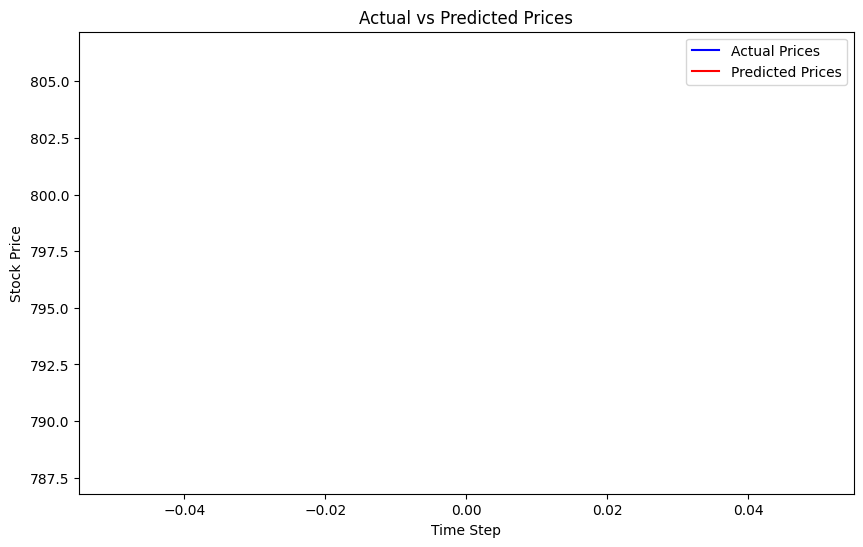

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("Google_Stock_Price_Test.csv")

# Check if 'Close' column exists
if 'Close' not in data.columns:
    raise KeyError("The dataset does not contain a 'Close' column. Please check the file.")

data = data['Close'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Augment data if too small
def augment_data(data, factor=5, noise_level=0.02):
    augmented_data = []
    for _ in range(factor):
        noise = noise_level * np.random.normal(size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

if len(scaled_data) < 10:  # Augment if dataset is too small
    print("Dataset is too small; augmenting data...")
    scaled_data = augment_data(scaled_data, factor=5, noise_level=0.02)

# Create sequences
def create_dataset(data, time_step=2):  # Set minimum time_step to 2
    X, y = [], []
    if len(data) <= time_step:
        raise ValueError(f"Insufficient data for the given time_step={time_step}. Data length: {len(data)}")
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Adjust time_step dynamically
time_step = max(2, min(30, len(scaled_data) - 1))

# Create sequences
X, y = create_dataset(scaled_data, time_step)

# Check the shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Reshape X
X = X.reshape(X.shape[0], X.shape[1], 1)

# Handle very small dataset: Use all data for training and testing
X_train, y_train = X, y
X_test, y_test = X, y

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

# Build model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=min(32, len(X_train)),  # Ensure batch size is valid
    verbose=1
)

# Evaluate model
mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

# Save the trained model
model.save("stock_price_prediction_model.h5")

# Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Make predictions and denormalize
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Denormalize actual values for comparison
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Debugging: Check predictions and actual values
print("First 5 predictions:", predictions[:5].flatten())
print("First 5 actual values:", y_test_denorm[:5].flatten())

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_denorm)), y_test_denorm, label='Actual Prices', color='blue')
plt.plot(range(len(predictions)), predictions, label='Predicted Prices', color='red')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
# Automatically adjust limits to visualize differences
plt.ylim(min(y_test_denorm.min(), predictions.min()) - 10, max(y_test_denorm.max(), predictions.max()) + 10)
plt.show()

